In [1]:
from manim import *
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.datasets as data
from sklearn.cluster import DBSCAN
import hdbscan
from matplotlib import collections

Manim Community v0.16.0.post0

# Setup

In [2]:
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 10, 'linewidths':0}

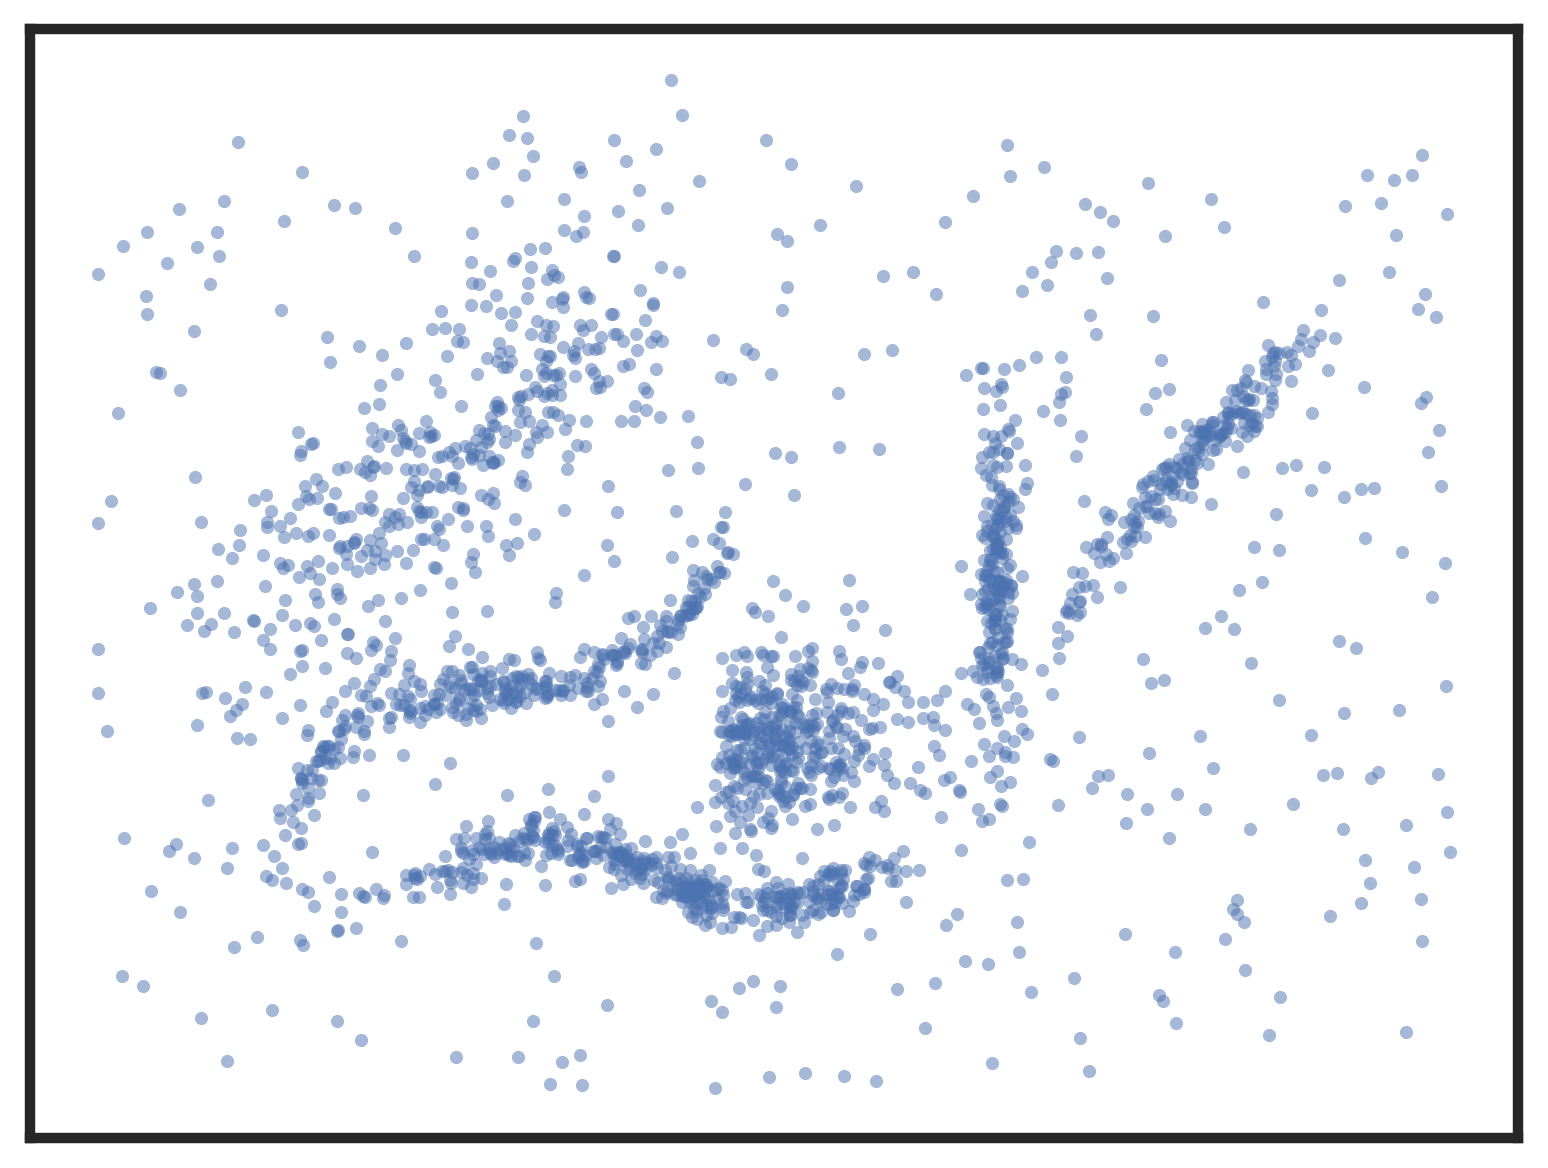

In [130]:
data = np.load('clusterable_data.npy')
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

# Finding the Core Distance for all Points

Animation 18: _MethodAnimation(ValueTracker): 100%|##########| 2/2 [00:00<00:00, 10.00it/s]


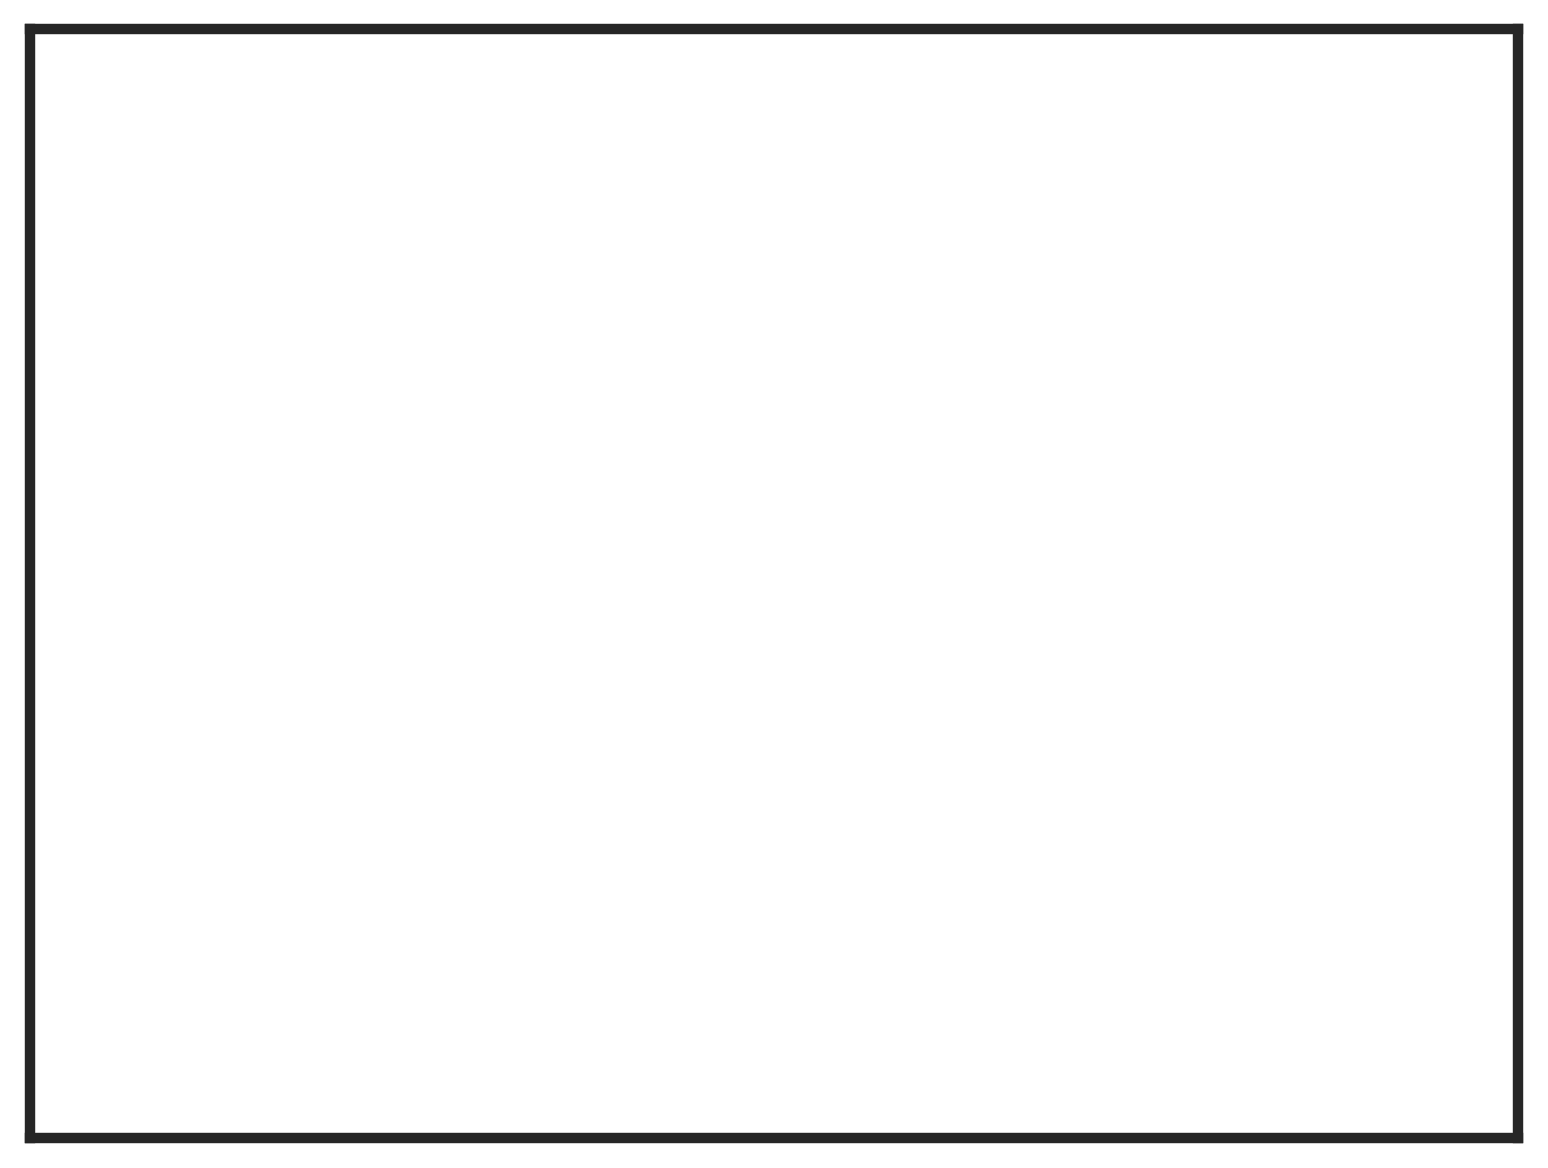

In [93]:
%%manim $paramp
plt.rcParams['figure.dpi'] = 300
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data.T[0], data.T[1], c='b', **plot_kwds)

# Plot circles
def plot_circle(data, circles, radii, k):
  
    # Remove ticks
    plt.xticks([])
    plt.yticks([])
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

    # Draw fig
    fig.canvas.draw()

    # Add the kth circle
    ax.add_artist(circles[k])
    ax.set_aspect('equal')
    ax.autoscale_view()

    # Create buffer
    buf = fig.canvas.buffer_rgba()

    # Convert buffer to image
    img = ImageMobject(buf).scale(1)
    plt.close(fig)

    return img
class Approx_Density(Scene):

    def construct(self):
        self.camera.background_color=WHITE

        # Calculate the pairwise distance of each pair of points
        dist_matrix = hdbscan.validity.pairwise_distances(data, metric='euclidean')

        # Calculate the k nearest neighbors distance for each point
        k = 5
        radii = [np.max(dist_matrix[idx][np.argpartition(dist_matrix[idx], k)[:k+1]]) for idx in range(len(data))]

        # Create circles
        circles = [plt.Circle(pt, radius) for idx, (pt, radius) in enumerate(zip(data, radii))]

        
        n = 0
        n_max = len(circles)-1

        tr_n = ValueTracker(n)
        image = plot_circle(data, circles, radii, n)

        self.add(image)

        def update_image(mob):
            new_mob = plot_circle(data, circles, radii, int(tr_n.get_value()))
            mob.become(new_mob)

        image.add_updater(update_image)
        # self.play(AnimationGroup(
        #     *[tr_n.animate.increment_value(1) for _ in range(n_max)],
        # ), run_time=5)
        for _ in range(n_max):
            self.play(tr_n.animate.increment_value(1), run_time=0.1)

        

# Test with GraphScene

In [32]:
test_data = np.load(r'..\data\clusterable_data.npy')
# test_data = data.make_blobs(n_samples=50, centers=3, n_features=2, random_state=42)[0]
dist_matrix = hdbscan.validity.pairwise_distances(test_data, metric='euclidean')
k = 5
radii = [np.max(dist_matrix[idx][np.argpartition(dist_matrix[idx], k)[:k+1]]) for idx in range(len(test_data))]

In [118]:
%%time
np.random.seed(20)
steps = np.random.choice(a=[-1, 0, 1], size=(100000,1000))
stop = steps.cumsum(0)
end_points= stop[-1]/stop[-1].max()
end_pointsX = end_points[0:499]
end_pointsY = end_points[500:-1]


CPU times: total: 1.34 s
Wall time: 3.95 s


In [8]:
param = '-v WARNING --disable_caching -ql --progress_bar leave Example'

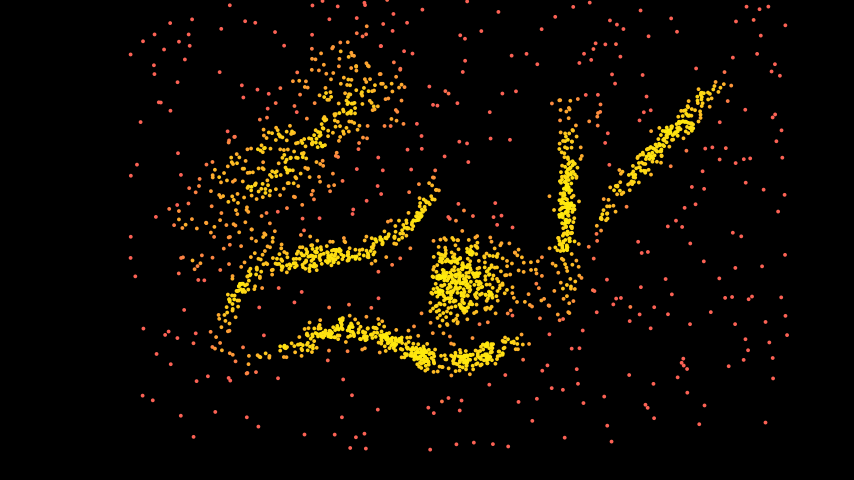

CPU times: total: 1.41 s
Wall time: 3.08 s


In [37]:
%%time
%%manim $param
class Example(Scene):
    def construct(self):
        # self.camera.background_color=WHITE
        dots = VGroup()
        for  (x, y), r in zip(test_data, radii / np.mean(radii)):
            c = interpolate_color(YELLOW, RED, min(1, r*0.5))
            dots.add(Dot(color=c,point=[x*10, y*7, 0]).scale(0.4))
        self.add(dots)

In [10]:
np.max(radii / np.mean(radii))

2.1915100659101223

In [38]:
param = '-v WARNING --disable_caching -ql --progress_bar leave LargeTreeGeneration'

In [39]:
%%manim $param

class LargeTreeGeneration(MovingCameraScene):
    DEPTH = 4
    CHILDREN_PER_VERTEX = 3
    LAYOUT_CONFIG = {"vertex_spacing": (0.5, 1)}
    VERTEX_CONF = {"radius": 0.25, "color": BLUE_B, "fill_opacity": 1}

    def expand_vertex(self, g, vertex_id: str, depth: int):
        new_vertices = [f"{vertex_id}/{i}" for i in range(self.CHILDREN_PER_VERTEX)]
        new_edges = [(vertex_id, child_id) for child_id in new_vertices]
        g.add_edges(
            *new_edges,
            vertex_config=self.VERTEX_CONF,
            positions={
                k: g.vertices[vertex_id].get_center() + 0.1 * DOWN for k in new_vertices
            },
        )
        if depth < self.DEPTH:
            for child_id in new_vertices:
                self.expand_vertex(g, child_id, depth + 1)

        return g

    def construct(self):
        g = Graph(["ROOT"], [], vertex_config=self.VERTEX_CONF)
        g = self.expand_vertex(g, "ROOT", 1)
        self.add(g)

        self.play(
            g.animate.change_layout(
                "tree",
                root_vertex="ROOT",
                layout_config=self.LAYOUT_CONFIG,
            )
        )
        self.play(self.camera.auto_zoom(g, margin=1), run_time=0.5)

Animation 0: _MethodAnimation(Graph on 121 vertices and 120 edges): 100%|##########| 15/15 [00:04<00:00,  3.45it/s]
Animation 1: _MethodAnimation(ScreenRectangle): 100%|##########| 8/8 [00:00<00:00,  8.56it/s]


In [43]:
param = '-v WARNING --disable_caching -ql --progress_bar leave ScreenRectExample'

In [82]:
class ScreenRectExample(Scene):

    def construct(self):

        # Create a ScreenRectangle
        spoiler_rect = ScreenRectangle()
        spoiler_rect.set_fill(GREY_D, 1)
        spoiler_rect.set_stroke(WHITE, 1)
        spoiler_rect.set(height=4.5)
        spoiler_rect.to_corner(DL)
        self.add(spoiler_rect)
        
        spoiler_rect.add(Text("Spoiler Alert!", color=BLACK).scale(0.5).shift(spoiler_rect.get_center()))



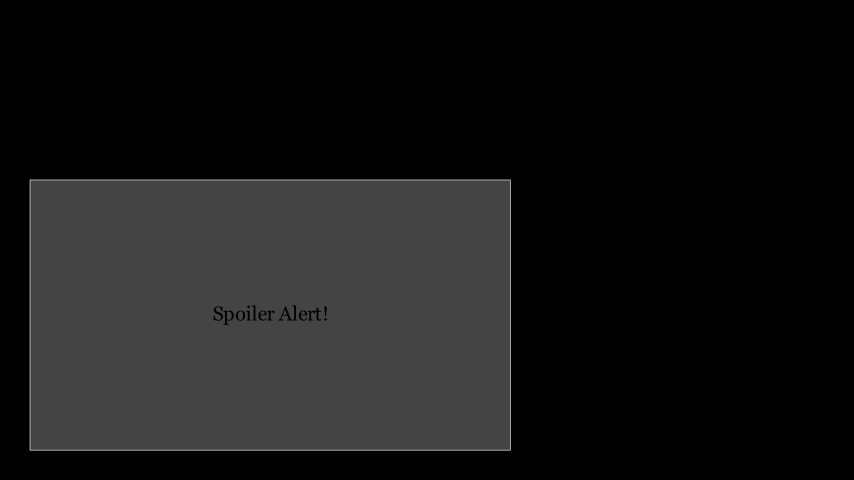

In [83]:
%%manim $param
plt.rcParams['figure.dpi'] = 300